# MAIA Demo

#### Many of MAIA's experiments are available in the [experiment browser](https://multimodal-interpretability.csail.mit.edu/maia/experiment-browser/) ####

In [1]:
%load_ext autoreload
%autoreload 2
# TODO - Convert to Demo

In [2]:
import sys
import os

#sys.path.append("src")

In [3]:
!export CUDA_VISIBLE_DEVICES=1
import os
from IPython import embed

import openai
from dotenv import load_dotenv

# Some imports require api key to be set ######
# Load environment variables
load_dotenv()

# Load OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")
#openai.organization = os.getenv("OPENAI_ORGANIZATION")
print(type(openai.api_key))
###############################################


from maia_api import System, Tools
from utils.DatasetExemplars import DatasetExemplars
from utils.main_utils import generate_save_path, create_unit_config
from utils.InterpAgent import InterpAgent

<class 'str'>


In [4]:
# Login for access to sd-3.5
from huggingface_hub import login
login()

In [16]:
maia_model = 'gpt-4o-mini'
task = 'neuron_description'
n_exemplars = 15
model_name = "finetune_resnet_gelu"
layer = "layer4"
neuron_num = 20
images_per_prompt = 1
path2save = '../results'
path2prompts = './prompts'
path2exemplars = './exemplars'
device = 1
text2image = 'sd'
debug = True

unit_config = {model_name: {layer: [neuron_num]}}

path2save = generate_save_path(path2save, maia_model, "test")
print(path2save)
os.makedirs(path2save, exist_ok=True)

../results/gpt-4o-mini/test


In [17]:
maia = InterpAgent(
            model_name=maia_model,
            prompt_path=path2prompts,
            api_prompt_name="api.txt",
            user_prompt_name=f"user_{task}.txt",
            overload_prompt_name="final.txt",
            end_experiment_token="[FINAL]",
            max_round_count=25,
            debug=debug
        )
net_dissect = DatasetExemplars(path2exemplars, n_exemplars, path2save, unit_config)
system = System(model_name, layer, neuron_num, net_dissect.thresholds, device)
tools = Tools(path2save, device, maia, system, net_dissect, images_per_prompt=images_per_prompt, text2image_model_name=text2image, image2text_model_name=maia)

print(tools.html_path)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

../results/gpt-4o-mini/test/experiment_0.html


In [23]:
maia.experiment_log = []
"""Test call_neuron with a single prompt"""
prompt = ["a dog standing on the grass"]
image = tools.text2image(prompt)
activations, images = system.call_neuron(image)
for activation, image in zip(activations, images):
    tools.display(image, f"Activation: {activation}")

RuntimeError: cutlassF: no kernel found to launch!

[{'role': 'system', 'content': [{'type': 'text', 'text': 'class System:\n    """\n    A Python class containing the vision model and the specific neuron to interact with.\n    \n    Attributes\n    ----------\n    neuron_num : int\n        The unit number of the neuron.\n    layer : string\n        The name of the layer where the neuron is located.\n    model_name : string\n        The name of the vision model.\n    model : nn.Module\n        The loaded PyTorch model.\n\n    Methods\n    -------\n    call_neuron(image_list: List[torch.Tensor]) -> Tuple[List[int], List[str]]\n        Returns the neuron activation for each image in the input image_list as well as the original image (encoded into a Base64 string).\n    """\n\n    def __init__(self, neuron_num: int, layer: str, model_name: str, device: str):\n        """\n        Initializes a neuron object by specifying its number and layer location and the vision model that the neuron belongs to.\n        Parameters\n        -------\n   
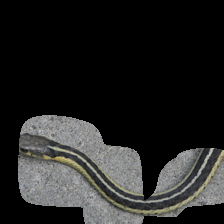
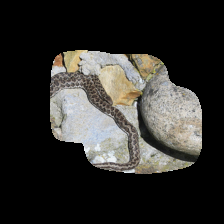
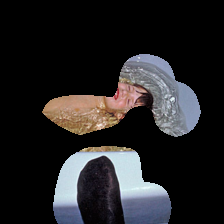
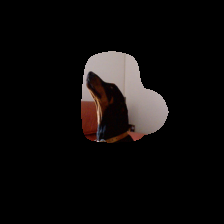
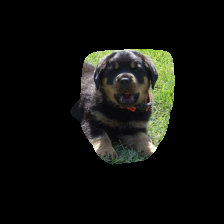
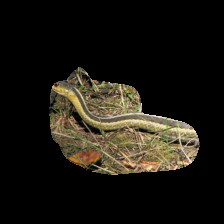
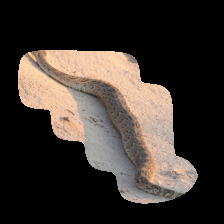
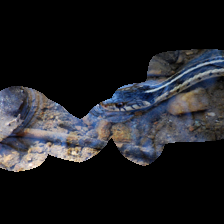
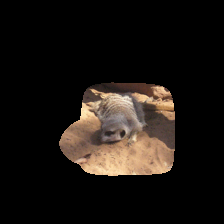
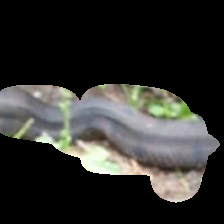
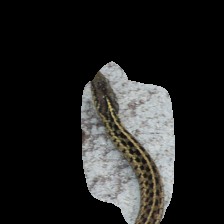
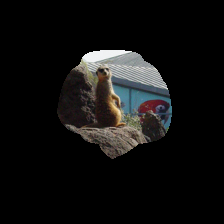
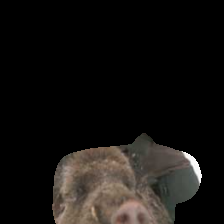
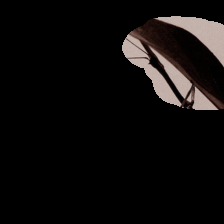
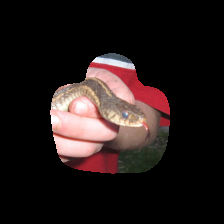
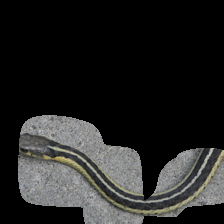
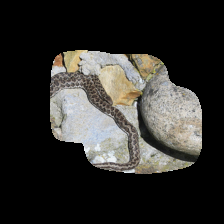
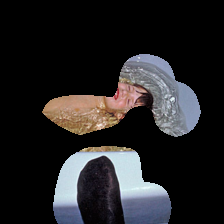
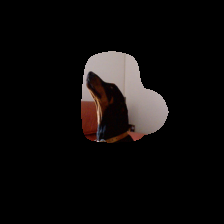
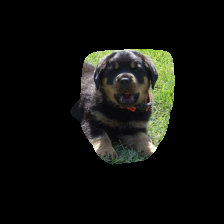
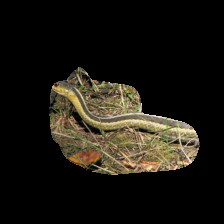
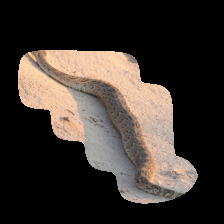
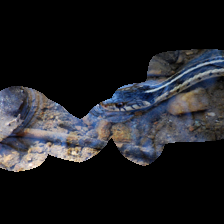
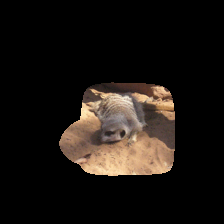
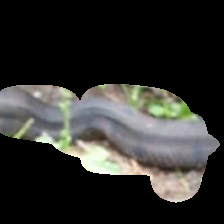
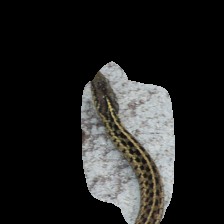
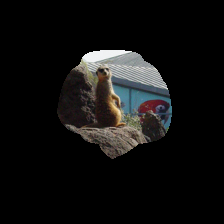
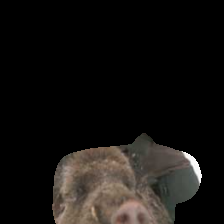
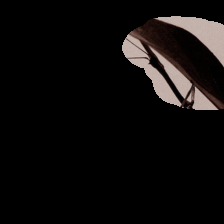
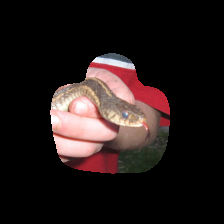

In [ ]:
tools.display(tools.dataset_exemplars())

In [ ]:
maia.run_experiment(system, tools, save_html=True)

In [ ]:
exemplar_data = tools.dataset_exemplars([1], system)
activations = [activation for activation, _ in exemplar_data[0]]
hypothesis = "Unit 1 is more selective to specific breeds of dogs, particularly those with long fur and fluffy grooming styles."
#hypothesis = "Unit 1 is more selective to specific breeds of dogs, particularly those with long fur and fluffy grooming styles."
context = f"Top 15 activations: {activations}"
result = tools.test_hypothesis(hypothesis, context, debug=True)
print(debug)

In [ ]:
exemplar_data = tools.dataset_exemplars([0, 1], system)
activations_0 = [activation for activation, _ in exemplar_data[0]]
activations_1 = [activation for activation, _ in exemplar_data[0]]
hypothesis = "Unit 1 is more selective to specific breeds of dogs, particularly those with long fur and fluffy grooming styles."
#hypothesis = "Unit 1 is more selective to specific breeds of dogs, particularly those with long fur and fluffy grooming styles."
context = f"Top 15 activations for unit 0: {activations_0}\n"
context += f"Top 15 activations for unit 1: {activations_1}"
result = tools.test_hypothesis(hypothesis, context, debug=True)
print(debug)

In [ ]:
tools.experiment_log = []
tools.update_experiment_log(role='system', type="text", type_content=maia_api) # update the experiment log with the system prompt
tools.update_experiment_log(role='user', type="text", type_content=user_query) # update the experiment log with the user prompt

j = 0
for i in range(20):
    print(i)
    maia_experiment = ask_agent(maia,tools.experiment_log) # ask maia for the next experiment given the results log to the experiment log (in the first round, the experiment log contains only the system prompt (maia api) and the user prompt (the query))
    tools.update_experiment_log(role='maia', type="text", type_content=str(maia_experiment)) # update the experiment log with maia's response (str casting is for exceptions)
    tools.generate_html() # generate the html file to visualize the experiment log
    if "[Difference]" in maia_experiment: break # stop the experiment if the response contains the final description. "[DESCRIPTION]" is the stopping signal.  
    experiment_output = experiment_env.execute_experiment(maia_experiment)
    if experiment_output != "":
        tools.update_experiment_log(role='user', type="text", type_content=experiment_output)

In [ ]:
tools.experiment_log = []
print(tools.visdiff(system, mode="OBJECTS"))
print("Done")

In [ ]:
tools.experiment_log = []
unit_ids = [0]
exemplar_data = tools.dataset_exemplars(unit_ids, system)
exemplars = [exemplar for _, exemplar in exemplar_data[0]]
print(tools.summarize_images(exemplars, debug=True))

In [ ]:
for log in tools.experiment_log:
    print(log)

In [ ]:
print(ask_agent("gpt-4o",[tools.experiment_log[-1]]))